In [1]:
CLASSIFIER_PATH = '../classifiers/RF_by-article_stats-and-counts.pickle'
DATASET_PATH    = '../generated_datasets/by-article_stats-and-counts.npz'
DOC_ENCODER_PATH = '../generated_datasets/DocEncoder_by-article_stats-and-counts.pickle'

In [2]:
import sys, os
import pickle
import numpy as np

## Load classifier
clf = pickle.load(open(CLASSIFIER_PATH, 'rb'))

## Load data (X, y)
data = np.load(DATASET_PATH)
X, y = data['X'], data['y']

## Load document encoder
sys.path.insert(1, os.path.join(sys.path[0], '../src'))
import document_encoder

encoder = pickle.load(open(DOC_ENCODER_PATH, 'rb'))
counter = encoder.counter  ## CountVectorizer

In [3]:
## FEATURE NAMES

## Invert word->idx mapping to get features' names
idx_to_word = {idx: '"{}"'.format(word) for word, idx in counter.vocabulary_.items()}
word_feature_names = [idx_to_word[i] for i in sorted(idx_to_word.keys())]

## Statistical features
statistical_feature_names = [
    'num_sentences',       ## Number of sentences
    'avg_sent_word_len',   ## Average sentence length in words
    'avg_sent_char_len',   ## Average sentence length in chars
    'var_sent_char_len',   ## Variance of sentence length in chars
    'avg_word_len',        ## Average word length
    'var_word_len',        ## Variance of word length
    'punct_freq',          ## Frequency of punctuation
    'capital_freq',        ## Frequency of capital letters
    'types_atoms_ratio'    ## Types to atoms ratio
]

feature_names = statistical_feature_names + word_feature_names

In [10]:
## Normalize Results
from sklearn.preprocessing import normalize

norm = np.linalg.norm(X, ord=3, axis=0)
X_norm = X / norm

In [11]:
y_pred = clf.predict(X)

hyper_pred = X_norm[(y_pred == 1), :] # Predicted hyperpartisan
mains_pred = X_norm[(y_pred == 0), :] # Predicted mainstream

hyper_gold = X_norm[(y == 1), :]      # Gold-standard Hyperpartisan
mains_gold = X_norm[(y == 0), :]      # Gold-standard Mainstream

In [12]:
hyper_mean = np.mean(hyper_pred, axis=0)
mains_mean = np.mean(mains_pred, axis=0)

hyper_gold_mean = np.mean(hyper_gold, axis=0)
mains_gold_mean = np.mean(mains_gold, axis=0)

In [13]:
rel_diffs = np.zeros(hyper_mean.shape)

for i in range(len(hyper_mean)):
    h, m = hyper_mean[i], mains_mean[i]
    rel_diffs[i] = max(h, m) - min(h, m)

In [14]:
sort_idx = np.argsort(rel_diffs)

for i in reversed(sort_idx):
    print('{} : {:.3}'.format(feature_names[i], rel_diffs[i]))
    print('\t Hyper: {:.4} ; Mains: {:.4}'.format(norm[i] * hyper_mean[i], norm[i] * mains_mean[i]))
    print('\t GOLD - H: {:.4} ; M: {:.4}'.format(norm[i] * hyper_gold_mean[i], norm[i] * mains_gold_mean[i]))

num_sentences : 0.0477
	 Hyper: 39.7 ; Mains: 19.42
	 GOLD - H: 37.5 ; M: 20.41
"just" : 0.0417
	 Hyper: 1.608 ; Mains: 0.6368
	 GOLD - H: 1.5 ; M: 0.6855
"want" : 0.0415
	 Hyper: 1.284 ; Mains: 0.4504
	 GOLD - H: 1.206 ; M: 0.484
"polit" : 0.041
	 Hyper: 1.371 ; Mains: 0.3487
	 GOLD - H: 1.336 ; M: 0.3538
"like" : 0.039
	 Hyper: 1.849 ; Mains: 0.707
	 GOLD - H: 1.744 ; M: 0.7518
"american" : 0.0365
	 Hyper: 1.81 ; Mains: 0.4262
	 GOLD - H: 1.706 ; M: 0.4668
"make" : 0.0336
	 Hyper: 1.375 ; Mains: 0.4843
	 GOLD - H: 1.315 ; M: 0.5061
"thing" : 0.0332
	 Hyper: 0.944 ; Mains: 0.3608
	 GOLD - H: 0.8782 ; M: 0.3907
"trump" : 0.0322
	 Hyper: 6.125 ; Mains: 2.54
	 GOLD - H: 5.857 ; M: 2.644
"year" : 0.0321
	 Hyper: 1.422 ; Mains: 0.5569
	 GOLD - H: 1.353 ; M: 0.5848
"presid" : 0.0318
	 Hyper: 2.772 ; Mains: 1.262
	 GOLD - H: 2.58 ; M: 1.351
"support" : 0.0302
	 Hyper: 1.034 ; Mains: 0.4358
	 GOLD - H: 0.9496 ; M: 0.4767
"know" : 0.0293
	 Hyper: 1.289 ; Mains: 0.5424
	 GOLD - H: 1.21 ; M: 0.5

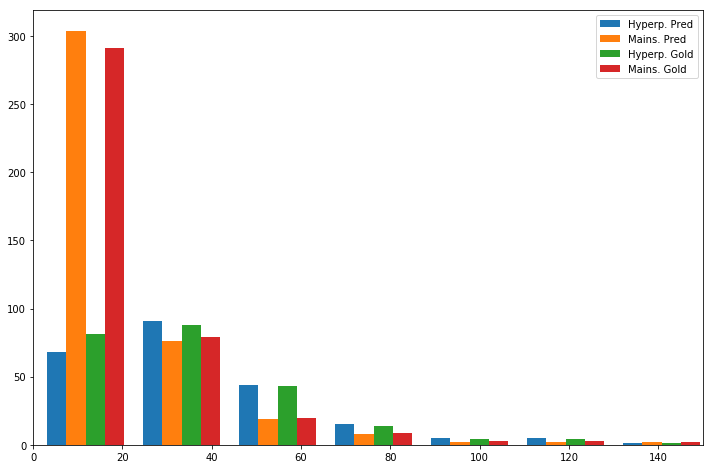

In [9]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

## Plot distributions of hyperpartisan/mainstream for a couple features sorted_idx[:3]
plt.hist([X[y_pred==1, 0], X[y_pred==0, 0], X[y==1, 0], X[y==0, 0]],
         label=['Hyperp. Pred', 'Mains. Pred', 'Hyperp. Gold', 'Mains. Gold'])
plt.xlim(0, 150)
plt.gcf().set_size_inches(12, 8)
plt.legend()